In [61]:
# Extract images from Zip file and move to 'images' folder
!mkdir images
!unzip images.zip
!mv *.png images/

import os
import shutil
import random
import pandas as pd

def move_random_images(src_dir, dest_dir, prefix, num_images):
    """
    Moves a specified number of random images with a given prefix from the source directory 
    to the destination directory.

    Args:
        src_dir (str): Source directory containing images.
        dest_dir (str): Destination directory to move images to.
        prefix (str): Prefix of images to search for.
        num_images (int): Number of images to move.
    """
    # Ensure destination directory exists
    os.makedirs(dest_dir, exist_ok=True)
    
    # Get all images with the specified prefix
    images = [img for img in os.listdir(src_dir) if img.startswith(prefix)]
    
    # Randomly select the specified number of images
    selected_images = random.sample(images, num_images)
    
    # Move each selected image to the destination directory
    for img in selected_images:
        shutil.move(os.path.join(src_dir, img), os.path.join(dest_dir, img))
        print(f"Moved {img} to {dest_dir}")

# Directory paths
source_directory = './images'  # Change as needed
destination_directory = './val_images'  # Folder to store selected images

# Move images
move_random_images(source_directory, destination_directory, 'BPF_', 25)
move_random_images(source_directory, destination_directory, 'LPF_', 25)
move_random_images(source_directory, destination_directory, 'HPF_', 25)
move_random_images(source_directory, destination_directory, 'notch_', 25)


def update_annotations(original_csv, moved_images_dir, new_csv):
    """
    Updates annotations by moving entries for specified images from the original CSV 
    to a new CSV.

    Args:
        original_csv (str): Path to the original annotations CSV.
        moved_images_dir (str): Directory containing moved images.
        new_csv (str): Path for the new annotations CSV.
    """
    # Read the original annotations CSV
    annotations = pd.read_csv(original_csv)
    
    # Extract the image filenames from the moved images directory
    moved_images = set(os.listdir(moved_images_dir))
    
    # Split the dataset into moved set and remaining set
    is_moved = annotations.iloc[:, 0].apply(lambda img_name: img_name in moved_images)
    moved_annotations = annotations[is_moved]
    remaining_annotations = annotations[~is_moved]
    
    # Write the moved annotations to a new CSV
    moved_annotations.to_csv(new_csv, index=False)
    
    # Optionally, you can overwrite the original CSV without the moved entries
    remaining_annotations.to_csv(original_csv, index=False, header=True)
    
    print(f"Moved {len(moved_annotations)} entries to {new_csv}.")

# Define paths
original_annotations_path = 'annotations.csv'  # Path to your original annotations file
moved_images_directory = './val_images'  # Directory where images were moved
new_annotations_path = 'val_annotations.csv'  # Path for the new validation annotations file

# Update annotations
update_annotations(original_annotations_path, moved_images_directory, new_annotations_path)

Archive:  images.zip
  inflating: images/BPF_length170.0_length2120.0_height20.0_sep20.0.png  
  inflating: images/BPF_length170.0_length2120.0_height20.0_sep35.0.png  
  inflating: images/BPF_length170.0_length2120.0_height20.0_sep50.0.png  
  inflating: images/BPF_length170.0_length2120.0_height20.0_sep65.0.png  
  inflating: images/BPF_length170.0_length2120.0_height20.0_sep80.0.png  
  inflating: images/BPF_length170.0_length2120.0_height25.0_sep20.0.png  
  inflating: images/BPF_length170.0_length2120.0_height25.0_sep35.0.png  
  inflating: images/BPF_length170.0_length2120.0_height25.0_sep50.0.png  
  inflating: images/BPF_length170.0_length2120.0_height25.0_sep65.0.png  
  inflating: images/BPF_length170.0_length2120.0_height25.0_sep80.0.png  
  inflating: images/BPF_length170.0_length2120.0_height30.0_sep20.0.png  
  inflating: images/BPF_length170.0_length2120.0_height30.0_sep35.0.png  
  inflating: images/BPF_length170.0_length2120.0_height30.0_sep50.0.png  
  inflating: imag

In [69]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torch.amp import GradScaler, autocast
import pandas as pd
from PIL import Image
import random
import time
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import re
import os
from tqdm import tqdm

# Set Environment variable for Cuda
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [70]:
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Initialize the custom dataset.

        Args:
            csv_file (str): Path to the CSV file containing image annotations.
            img_dir (str): Directory path where images are stored.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.annotations = pd.read_csv(csv_file)    # Read annotations CSV file
        self.img_dir = img_dir                      # Image directory path
        self.transform = transform                  # Image transformer (for manipulating image sizes)

    def __len__(self):
        """
        Return the total number of samples in the dataset.

        Returns:
            int: Number of samples in the dataset (size of annotations file).
        """
        return len(self.annotations)  # Size of annotations file

    def __getitem__(self, index):
        """
        Retrieve a sample from the dataset at the specified index.

        Args:
            index (int): Index of the sample to retrieve.

        Returns:
            Tuple[image, torch.Tensor]: A tuple of the transformed image and its corresponding frequency annotations.
        """
        img_name = self.annotations.iloc[index, 0]  # Get the name of the image at the specified index
        image = Image.open(f"{self.img_dir}/{img_name}").convert('RGB')  # Open the image and convert to RGB if not already

        if self.transform:
            image = self.transform(image)  # Transform image (resize and change to Tensor type)

        frequencies = self.annotations.iloc[index, 1:].values.astype(float)  # Extract annotations (frequency response values)
        
        return image, torch.tensor(frequencies, dtype=torch.float32)  # Return the image and its annotation (both as tensors)

In [71]:
# Define Global Variables
image_width = 450                       # Set image width to be used for resizing images
image_height = 300                      # Set image height to be used for resizing images
train_img_dir = './images'              # Path to directory containing images for training
train_csv_file = './annotations.csv'    # Path to CSV file containing annotations for the images
val_img_dir = './val_images'            # Path to directory containing images for training
val_csv_file = './val_annotations.csv'  # Path to CSV file containing annotations for the images
num_outputs = 381                       # Number of output classes or target values for the model

# Define image transformer (changes input image dimensions and changes them to tensors)
transform = transforms.Compose([
    transforms.Resize((image_height, image_width)),  # Resize images to the specified height and width
    transforms.ToTensor(),                           # Convert images to PyTorch tensors
])

# Create and load dataset
train_dataset = CustomDataset(csv_file=train_csv_file, img_dir=train_img_dir, transform=transform)  # Initialize training dataset with transformations
val_dataset = CustomDataset(csv_file=val_csv_file, img_dir=val_img_dir, transform=transform)        # Initialize validation dataset

# Create data loaders for training and validation datasets
train_loader = DataLoader(
    train_dataset,  # Dataset for training
    batch_size=16,  # Number of samples per batch for training
    shuffle=True    # Shuffle training data after every epoch
)
val_loader = DataLoader(
    val_dataset,    # Dataset for validation
    batch_size=4,   # Number of samples per batch for validation
    shuffle=True    # Shuffle validation data to ensure randomness
)

In [72]:
def calculate_linears(num_layers: int, dim: list, conv_filter_size: int, conv_stride: int, maxp_filter_size: int, maxp_stride: int, padding: int) -> list:
    """
    Calculate the output dimensions of a series of convolutional and max pooling layers
    (Calculates the number of input neurons for the linear fully-connected layer).

    Args:
        num_layers (int): Number of convolutional and pooling layers.
        dim (list): Initial dimensions [width, height] of the input.
        conv_filter_size (int): Size of the convolutional filter (assumed square).
        conv_stride (int): Stride for the convolutional layers.
        maxp_filter_size (int): Size of the max pooling filter (assumed square).
        maxp_stride (int): Stride for the max pooling operation.
        padding (int): Amount of zero-padding added to both sides of the input.

    Returns:
        list: Final dimensions [width, height] after all layers are applied.
    """
    output = [dim[0], dim[1]]  # Initialize with the input dimensions (width, height)
    for i in range(num_layers):
        # Calculate convolution output dimensions using the given formula
        conv_output_width = ((output[0] - conv_filter_size + (2 * padding)) / conv_stride) + 1
        conv_output_height = ((output[1] - conv_filter_size + (2 * padding)) / conv_stride) + 1
        
        # Update output to convolution result dimensions
        output = [conv_output_width, conv_output_height]
        
        # Calculate max pooling output dimensions using the given formula
        pool_output_width = ((output[0] - maxp_filter_size) / maxp_stride) + 1
        pool_output_height = ((output[1] - maxp_filter_size) / maxp_stride) + 1
        
        # Update output to pooling result dimensions, converting to int for layer compatibility
        output = [int(pool_output_width), int(pool_output_height)]
    
    return output  # Return final dimensions after all layers are applied

In [73]:
# Circuit Convolution neural network configuration
input_layers = 3  # Number of input layers, typically corresponding to the color channels of an image (e.g., RGB)
Conv1_output_layers = 32  # Number of output channels for the first convolutional layer
Conv2_output_layers = Conv1_output_layers * 2  # Number of output channels for the second convolutional layer, doubling the previous layer
Conv3_output_layers = Conv2_output_layers * 2  # Number of output channels for the third convolutional layer, doubling again

conv_filter_size = 3  # Size of the convolutional filters (3x3)
conv_stride = 1  # Stride of the convolutional layer
maxp_filter_size = 2  # Size of the max pooling filters (2x2)
maxp_stride = 2  # Stride of the max pooling layer
padding = 1  # Padding added to the input of convolutional layers

# Calculate output dimensions after convolutional and pooling layers
linear_layers = calculate_linears(
    num_layers=3,  # Number of convolutional/pooling layers
    dim=[image_width, image_height],  # Initial image dimensions
    conv_filter_size=conv_filter_size,  # Convolution filter size
    conv_stride=conv_stride,  # Convolution stride
    maxp_filter_size=maxp_filter_size,  # Max pooling filter size
    maxp_stride=maxp_stride,  # Max pooling stride
    padding=padding  # Padding for convolutional layers
)

conv_flatten_widths = linear_layers[0]  # Final width after the convolutional layers
conv_flatten_heights = linear_layers[1]  # Final height after the convolutional layers

# Configuration for fully connected (linear) layers
Lin1_output_layers = 1024  # Number of output units for the first linear layer
Lin2_output_layers = Lin1_output_layers  # Number of output units for the second linear layer
Lin3_output_layers = Lin2_output_layers  # Number of output units for the third linear layer
Lin4_output_layers = Lin3_output_layers // 2  # Number of output units for the fourth linear layer, halving the previous layer
Lin5_output_layers = Lin4_output_layers // 2  # Number of output units for the fifth linear layer, halving again

dropout_prob = 0.1  # Probability for dropout, a regularization technique

# Calculate the number of neurons for the fully-connected layer after flattening
conv_flat_output = conv_flatten_widths * conv_flatten_heights * Conv3_output_layers  # Total number of neurons

In [74]:
class CircuitFrequencyResponseModel(nn.Module):
    def __init__(self, output_length):
        """
        Initialize the Circuit Frequency Response Model.

        Args:
            output_length (int): Length of the model output.
        """
        super(CircuitFrequencyResponseModel, self).__init__()
        
        # Convolutional layers for feature extraction
        self.conv1 = nn.Conv2d(input_layers, Conv1_output_layers, kernel_size=conv_filter_size, padding=padding)  # First convolutional layer
        self.conv2 = nn.Conv2d(Conv1_output_layers, Conv2_output_layers, kernel_size=conv_filter_size, padding=padding)  # Second convolutional layer
        self.conv3 = nn.Conv2d(Conv2_output_layers, Conv3_output_layers, kernel_size=conv_filter_size, padding=padding)  # Third convolutional layer
        
        self.pool = nn.MaxPool2d(kernel_size=maxp_filter_size, stride=maxp_stride)  # Max pooling layer
        
        # Fully connected layers
        self.fc1 = nn.Linear(conv_flat_output, Lin1_output_layers)  # First fully connected layer
        self.fc2 = nn.Linear(Lin1_output_layers, Lin2_output_layers)  # Second fully connected layer
        self.fc3 = nn.Linear(Lin2_output_layers, Lin3_output_layers)  # Third fully connected layer
        self.fc4 = nn.Linear(Lin3_output_layers, Lin4_output_layers)  # Fourth fully connected layer
        self.fc5 = nn.Linear(Lin4_output_layers, Lin5_output_layers)  # Fifth fully connected layer
        
        self.dropout = nn.Dropout(p=dropout_prob)  # Dropout layer to prevent overfitting
        
        # Output layer
        # Originally commented out, using Lin3_output_layers
        # self.fc_out = nn.Linear(Lin3_output_layers, output_length)
        self.fc_out = nn.Linear(Lin5_output_layers, output_length)  # Linear layer for the final output
        
        self.output_length = output_length  # Record the output length for reference

    def forward(self, x):
        """
        Define the forward pass of the model.
        
        Args:
            x (torch.Tensor): Input tensor representing a batch of images.
        
        Returns:
            torch.Tensor: Output tensor after passing through the network.
        """
        # Forward pass through convolutional layers with ReLU and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Flatten feature map before fully connected layers
        x = x.view(x.size(0), -1)
        
        # Forward pass through fully connected layers with ReLU and dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.dropout(F.relu(self.fc4(x)))
        x = self.dropout(F.relu(self.fc5(x)))
        
        # Final output layer
        x = self.fc_out(x)
        
        return x

In [75]:
# Training Variables (Define the model, loss function, optimizer, and scheduler)
model = CircuitFrequencyResponseModel(output_length=num_outputs)  # Initialize the model with the specified output length
criterion = nn.MSELoss()  # Define the loss function (Mean Squared Error Loss)
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)  # Initialize the optimizer (Adam) with a learning rate; alternatives commented
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau( # Initialize a learning rate scheduler to reduce the learning rate when a plateau in validation loss is observed.
    optimizer,            # Optimizer whose learning rate will be adjusted
    mode='min',           # Mode of optimization ('min' since lower validation loss is better)
    factor=0.75,          # Factor by which the learning rate will be reduced
    patience=20,          # Number of epochs with no improvement after which learning rate will be reduced
    threshold=0.001,      # Threshold for measuring the new optimum for early stopping
    verbose=True          # Print a message when learning rate is updated
)
# Move model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if CUDA is available, use GPU if so, else use CPU
model.to(device)  # Transfer model to the selected device

start_epoch = 0  # Starting epoch number, useful for resuming training
num_epochs = 600  # Total number of epochs for training

In [ ]:
def load_checkpoint():
    """
    Load a training checkpoint from disk and resume training from a specified epoch.

    Raises:
        FileNotFoundError: If the checkpoint file does not exist at the specified path.
    """
    checkpoint_path = f"CapstoneFull_checkpoint_epoch_{desired_epoch}.pth"  # Path to the checkpoint file for the desired epoch

    try:
        # Load the checkpoint data
        checkpoint = torch.load(checkpoint_path)
        
        # Load the model state from the checkpoint
        model.load_state_dict(checkpoint['model_state_dict'])
        
        # Load the optimizer state from the checkpoint
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
        # Load the scheduler state from the checkpoint
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        
        # Update the starting epoch number to resume training
        start_epoch = checkpoint['epoch']  # Start from the epoch following the one in the checkpoint
        print(f"Resuming training from epoch {start_epoch}")  # Print a message indicating resumption

    except FileNotFoundError:
        # Print a message if no checkpoint is found
        print("No checkpoint found, starting training from scratch.")

In [76]:
# Loop over the dataset multiple times, where each loop is a complete pass over the data (an epoch)
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode to ensure training-specific operations are active
    running_loss = 0.0  # Initialize the running loss to accumulate total loss for the epoch
    
    # Iterate over batches of images and targets from the training data
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, targets = images.to(device), targets.to(device)  # Move images and targets to the designated device (CPU or GPU)
        optimizer.zero_grad()     # Clear the gradients of all optimized tensors
        
        outputs = model(images)   # Forward pass: compute the model output for the batch of images
        loss = criterion(outputs.squeeze(-1), targets)  # Compute the loss between model predictions and actual targets
        
        loss.backward()  # Backward pass: compute gradients of the loss with respect to model parameters
        optimizer.step()  # Update model parameters based on the computed gradients
        
        running_loss += loss.item()  # Accumulate the batch loss into running loss
    
    # Compute the average loss for the epoch
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")  # Print the average training loss for the epoch
    
    model.eval()  # Set the model to evaluation mode, affecting certain layers which behave differently during evaluation (e.g., dropout)
    val_loss = 0.0  # Initialize validation loss accumulator
    
    # Disable gradient computation for validation to save memory and computation
    with torch.no_grad():
        # Iterate over validation dataset
        for val_images, val_targets in val_loader:
            val_images, val_targets = val_images.to(device), val_targets.to(device)  # Move validation data to the device
            val_outputs = model(val_images)  # Compute model output for validation data
            v_loss = criterion(val_outputs.squeeze(-1), val_targets)  # Calculate validation loss
            val_loss += v_loss.item()  # Accumulate validation loss
    
    # Compute the average validation loss for the epoch
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")  # Print the average validation loss
    
    scheduler.step(avg_val_loss)  # Update the learning rate based on validation loss
    
    # Save a checkpoint every 50 epochs
    if (epoch + 1) % 50 == 0:
        checkpoint = {
            'epoch': epoch + 1,                        # Current epoch number
            'model_state_dict': model.state_dict(),    # Model parameters
            'optimizer_state_dict': optimizer.state_dict(),  # Optimizer state
            'scheduler_state_dict': scheduler.state_dict(),  # Scheduler state
            'loss': avg_loss                           # Latest training loss
        }
        torch.save(checkpoint, f"Checkpoint_epoch_{epoch + 1}.pth")  # Save the checkpoint to a file
        print(f"Checkpoint saved at epoch {epoch + 1}")  # Notify that checkpoint is saved

print("Training complete!")  # Indicate that training has finished

# Save the final model parameters to a file
torch.save(model.state_dict(), f'CapstoneFull_Complete_V3.pth')

Epoch 1/600: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:42<00:00,  3.56it/s]


Epoch [1/600], Loss: 375.7106


Epoch 2/600: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [2/600], Loss: 140.5255


Epoch 3/600: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [3/600], Loss: 116.2489


Epoch 4/600: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [4/600], Loss: 96.5365


Epoch 5/600: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.83it/s]


Epoch [5/600], Loss: 129.3618


Epoch 6/600: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:42<00:00,  3.55it/s]


Epoch [6/600], Loss: 86.5025


Epoch 7/600: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [7/600], Loss: 76.8782


Epoch 8/600: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.84it/s]


Epoch [8/600], Loss: 72.5371


Epoch 9/600: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.78it/s]


Epoch [9/600], Loss: 67.9395


Epoch 10/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.84it/s]


Epoch [10/600], Loss: 60.4688


Epoch 11/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [11/600], Loss: 55.1061


Epoch 12/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.63it/s]


Epoch [12/600], Loss: 57.2102


Epoch 13/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.78it/s]


Epoch [13/600], Loss: 48.4282


Epoch 14/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [14/600], Loss: 46.1931


Epoch 15/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [15/600], Loss: 44.1223


Epoch 16/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [16/600], Loss: 42.8865


Epoch 17/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [17/600], Loss: 41.6656


Epoch 18/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.79it/s]


Epoch [18/600], Loss: 40.3477


Epoch 19/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.58it/s]


Epoch [19/600], Loss: 39.4073


Epoch 20/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [20/600], Loss: 39.7628


Epoch 21/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [21/600], Loss: 37.2905


Epoch 22/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [22/600], Loss: 37.3357


Epoch 23/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [23/600], Loss: 35.5042


Epoch 24/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [24/600], Loss: 35.3463


Epoch 25/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [25/600], Loss: 33.7011


Epoch 26/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.57it/s]


Epoch [26/600], Loss: 34.7078


Epoch 27/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [27/600], Loss: 33.0337


Epoch 28/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [28/600], Loss: 33.5941


Epoch 29/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [29/600], Loss: 30.8694


Epoch 30/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [30/600], Loss: 41.5211


Epoch 31/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [31/600], Loss: 34.0935


Epoch 32/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [32/600], Loss: 32.0132


Epoch 33/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.59it/s]


Epoch [33/600], Loss: 30.6437


Epoch 34/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [34/600], Loss: 29.4512


Epoch 35/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:38<00:00,  3.86it/s]


Epoch [35/600], Loss: 30.3399


Epoch 36/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:38<00:00,  3.86it/s]


Epoch [36/600], Loss: 28.6706


Epoch 37/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.79it/s]


Epoch [37/600], Loss: 28.7674


Epoch 38/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:37<00:00,  3.95it/s]


Epoch [38/600], Loss: 28.2924


Epoch 39/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.79it/s]


Epoch [39/600], Loss: 27.5161


Epoch 40/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.64it/s]


Epoch [40/600], Loss: 28.5732


Epoch 41/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.83it/s]


Epoch [41/600], Loss: 27.2316


Epoch 42/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:38<00:00,  3.86it/s]


Epoch [42/600], Loss: 28.6290


Epoch 43/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:38<00:00,  3.86it/s]


Epoch [43/600], Loss: 27.8639


Epoch 44/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:38<00:00,  3.86it/s]


Epoch [44/600], Loss: 27.1408


Epoch 45/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:38<00:00,  3.86it/s]


Epoch [45/600], Loss: 26.5052


Epoch 46/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:38<00:00,  3.85it/s]


Epoch [46/600], Loss: 25.6931


Epoch 47/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.61it/s]


Epoch [47/600], Loss: 26.2616


Epoch 48/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.85it/s]


Epoch [48/600], Loss: 25.2709


Epoch 49/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [49/600], Loss: 25.6496


Epoch 50/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.72it/s]


Epoch [50/600], Loss: 25.0959
Model saved at epoch 50


Epoch 51/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [51/600], Loss: 24.5937


Epoch 52/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [52/600], Loss: 24.9017


Epoch 53/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:42<00:00,  3.50it/s]


Epoch [53/600], Loss: 24.1827


Epoch 54/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.71it/s]


Epoch [54/600], Loss: 25.0150


Epoch 55/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.71it/s]


Epoch [55/600], Loss: 26.6795


Epoch 56/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.71it/s]


Epoch [56/600], Loss: 24.7762


Epoch 57/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [57/600], Loss: 23.8417


Epoch 58/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:43<00:00,  3.49it/s]


Epoch [58/600], Loss: 23.1137


Epoch 59/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.71it/s]


Epoch [59/600], Loss: 23.0474


Epoch 60/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.72it/s]


Epoch [60/600], Loss: 22.2600


Epoch 61/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.71it/s]


Epoch [61/600], Loss: 22.9663


Epoch 62/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [62/600], Loss: 22.3120


Epoch 63/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.71it/s]


Epoch [63/600], Loss: 22.3843


Epoch 64/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:43<00:00,  3.48it/s]


Epoch [64/600], Loss: 22.2270


Epoch 65/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [65/600], Loss: 21.8569


Epoch 66/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [66/600], Loss: 21.5104


Epoch 67/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [67/600], Loss: 21.8922


Epoch 68/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.72it/s]


Epoch [68/600], Loss: 21.0505


Epoch 69/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:42<00:00,  3.50it/s]


Epoch [69/600], Loss: 21.3826


Epoch 70/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [70/600], Loss: 21.0280


Epoch 71/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.72it/s]


Epoch [71/600], Loss: 20.4098


Epoch 72/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.72it/s]


Epoch [72/600], Loss: 19.9247


Epoch 73/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.71it/s]


Epoch [73/600], Loss: 21.3173


Epoch 74/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:42<00:00,  3.54it/s]


Epoch [74/600], Loss: 20.1924


Epoch 75/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [75/600], Loss: 19.6428


Epoch 76/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.72it/s]


Epoch [76/600], Loss: 19.7075


Epoch 77/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [77/600], Loss: 19.7105


Epoch 78/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [78/600], Loss: 19.1370


Epoch 79/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [10:27:51<00:00, 251.14s/it]


Epoch [79/600], Loss: 19.5022


Epoch 80/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.62it/s]


Epoch [80/600], Loss: 21.6621


Epoch 81/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [81/600], Loss: 19.4992


Epoch 82/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.83it/s]


Epoch [82/600], Loss: 18.7410


Epoch 83/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [83/600], Loss: 18.5707


Epoch 84/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [84/600], Loss: 18.6610


Epoch 85/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [85/600], Loss: 18.4734


Epoch 86/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [86/600], Loss: 18.4081


Epoch 87/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [87/600], Loss: 17.9102


Epoch 88/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.79it/s]


Epoch [88/600], Loss: 17.5797


Epoch 89/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [89/600], Loss: 18.6929


Epoch 90/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [90/600], Loss: 18.1166


Epoch 91/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [91/600], Loss: 17.1071


Epoch 92/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [92/600], Loss: 17.0334


Epoch 93/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [93/600], Loss: 16.9592


Epoch 94/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [94/600], Loss: 56.6865


Epoch 95/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [95/600], Loss: 23.1545


Epoch 96/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [96/600], Loss: 18.2582


Epoch 97/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [97/600], Loss: 17.8392


Epoch 98/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [98/600], Loss: 16.7352


Epoch 99/600: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [99/600], Loss: 16.8553


Epoch 100/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [100/600], Loss: 16.4164
Model saved at epoch 100


Epoch 101/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.64it/s]


Epoch [101/600], Loss: 15.1893


Epoch 102/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [102/600], Loss: 14.9248


Epoch 103/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [103/600], Loss: 14.3794


Epoch 104/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [104/600], Loss: 14.6851


Epoch 105/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [105/600], Loss: 14.7033


Epoch 106/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [106/600], Loss: 14.5212


Epoch 107/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [107/600], Loss: 14.4255


Epoch 108/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [108/600], Loss: 14.2070


Epoch 109/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [109/600], Loss: 14.0735


Epoch 110/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [110/600], Loss: 13.9959


Epoch 111/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [111/600], Loss: 14.3887


Epoch 112/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [112/600], Loss: 13.9572


Epoch 113/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [113/600], Loss: 14.1816


Epoch 114/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [114/600], Loss: 13.9689


Epoch 115/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [115/600], Loss: 14.0107


Epoch 116/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [116/600], Loss: 14.0012


Epoch 117/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [117/600], Loss: 13.9679


Epoch 118/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [118/600], Loss: 13.5931


Epoch 119/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [119/600], Loss: 13.9196


Epoch 120/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [120/600], Loss: 13.5671


Epoch 121/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [121/600], Loss: 13.2174


Epoch 122/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [122/600], Loss: 14.1980


Epoch 123/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [123/600], Loss: 13.5571


Epoch 124/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [124/600], Loss: 13.8836


Epoch 125/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [125/600], Loss: 13.5745


Epoch 126/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [126/600], Loss: 13.2809


Epoch 127/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [127/600], Loss: 12.8914


Epoch 128/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [128/600], Loss: 12.9448


Epoch 129/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [129/600], Loss: 12.9874


Epoch 130/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [130/600], Loss: 12.9852


Epoch 131/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [131/600], Loss: 13.1399


Epoch 132/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [132/600], Loss: 13.0804


Epoch 133/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [133/600], Loss: 12.8718


Epoch 134/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [134/600], Loss: 12.7037


Epoch 135/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [135/600], Loss: 12.6590


Epoch 136/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [136/600], Loss: 12.4503


Epoch 137/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [137/600], Loss: 12.7990


Epoch 138/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [138/600], Loss: 12.7489


Epoch 139/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [139/600], Loss: 12.7496


Epoch 140/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [140/600], Loss: 12.3018


Epoch 141/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [141/600], Loss: 12.1425


Epoch 142/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [142/600], Loss: 12.6087


Epoch 143/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [143/600], Loss: 12.3266


Epoch 144/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [144/600], Loss: 12.3850


Epoch 145/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [145/600], Loss: 12.0970


Epoch 146/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [146/600], Loss: 12.1553


Epoch 147/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [147/600], Loss: 12.2416


Epoch 148/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [148/600], Loss: 12.4000


Epoch 149/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [149/600], Loss: 12.0659


Epoch 150/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [150/600], Loss: 12.0672
Model saved at epoch 150


Epoch 151/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:42<00:00,  3.56it/s]


Epoch [151/600], Loss: 12.0226


Epoch 152/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [152/600], Loss: 11.8657


Epoch 153/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [153/600], Loss: 12.5698


Epoch 154/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [154/600], Loss: 11.9076


Epoch 155/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [155/600], Loss: 11.7057


Epoch 156/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [156/600], Loss: 11.4384


Epoch 157/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [157/600], Loss: 11.6538


Epoch 158/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [158/600], Loss: 11.4812


Epoch 159/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [159/600], Loss: 11.5181


Epoch 160/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [160/600], Loss: 11.6164


Epoch 161/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [161/600], Loss: 11.4989


Epoch 162/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [162/600], Loss: 11.2444


Epoch 163/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [163/600], Loss: 11.1352


Epoch 164/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [164/600], Loss: 11.2202


Epoch 165/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [165/600], Loss: 11.2917


Epoch 166/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [166/600], Loss: 11.3014


Epoch 167/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [167/600], Loss: 11.5915


Epoch 168/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [168/600], Loss: 11.1245


Epoch 169/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:42<00:00,  3.57it/s]


Epoch [169/600], Loss: 11.3842


Epoch 170/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.83it/s]


Epoch [170/600], Loss: 11.2390


Epoch 171/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [171/600], Loss: 11.1648


Epoch 172/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [172/600], Loss: 11.1866


Epoch 173/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [173/600], Loss: 10.9179


Epoch 174/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [174/600], Loss: 10.9259


Epoch 175/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [175/600], Loss: 10.9126


Epoch 176/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [176/600], Loss: 11.0417


Epoch 177/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [177/600], Loss: 10.8285


Epoch 178/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.83it/s]


Epoch [178/600], Loss: 11.3038


Epoch 179/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [179/600], Loss: 11.1007


Epoch 180/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.83it/s]


Epoch [180/600], Loss: 11.0850


Epoch 181/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [181/600], Loss: 10.7643


Epoch 182/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [182/600], Loss: 10.5965


Epoch 183/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [183/600], Loss: 10.5332


Epoch 184/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.82it/s]


Epoch [184/600], Loss: 10.9086


Epoch 185/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [185/600], Loss: 10.6851


Epoch 186/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [186/600], Loss: 10.5625


Epoch 187/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [187/600], Loss: 10.3971


Epoch 188/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [188/600], Loss: 10.2559


Epoch 189/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [189/600], Loss: 10.4919


Epoch 190/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [190/600], Loss: 10.6249


Epoch 191/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [191/600], Loss: 10.1275


Epoch 192/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [192/600], Loss: 10.3390


Epoch 193/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [193/600], Loss: 10.3869


Epoch 194/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [194/600], Loss: 10.2148


Epoch 195/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [195/600], Loss: 10.1286


Epoch 196/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [196/600], Loss: 10.2483


Epoch 197/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [197/600], Loss: 10.3638


Epoch 198/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [198/600], Loss: 10.3573


Epoch 199/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [199/600], Loss: 10.6031


Epoch 200/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.64it/s]


Epoch [200/600], Loss: 10.1347
Model saved at epoch 200


Epoch 201/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.64it/s]


Epoch [201/600], Loss: 9.6652


Epoch 202/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [202/600], Loss: 9.6841


Epoch 203/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [203/600], Loss: 9.3385


Epoch 204/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [204/600], Loss: 9.5860


Epoch 205/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [205/600], Loss: 9.3913


Epoch 206/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [206/600], Loss: 9.3701


Epoch 207/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.63it/s]


Epoch [207/600], Loss: 9.1212


Epoch 208/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [208/600], Loss: 9.4108


Epoch 209/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [209/600], Loss: 9.2183


Epoch 210/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [210/600], Loss: 9.3981


Epoch 211/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [211/600], Loss: 9.2846


Epoch 212/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [212/600], Loss: 9.2447


Epoch 213/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [213/600], Loss: 9.2769


Epoch 214/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [214/600], Loss: 9.0850


Epoch 215/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [215/600], Loss: 9.0736


Epoch 216/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [216/600], Loss: 9.4010


Epoch 217/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [217/600], Loss: 9.2160


Epoch 218/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [218/600], Loss: 9.3666


Epoch 219/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [219/600], Loss: 9.2666


Epoch 220/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [220/600], Loss: 9.3584


Epoch 221/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [221/600], Loss: 9.0682


Epoch 222/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [222/600], Loss: 9.1937


Epoch 223/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [223/600], Loss: 9.2374


Epoch 224/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.63it/s]


Epoch [224/600], Loss: 9.1709


Epoch 225/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [225/600], Loss: 9.1786


Epoch 226/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [226/600], Loss: 9.1218


Epoch 227/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [227/600], Loss: 8.9986


Epoch 228/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [228/600], Loss: 9.2389


Epoch 229/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [229/600], Loss: 9.0257


Epoch 230/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [230/600], Loss: 9.0444


Epoch 231/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [231/600], Loss: 8.8689


Epoch 232/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [232/600], Loss: 8.8783


Epoch 233/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [233/600], Loss: 8.9918


Epoch 234/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [234/600], Loss: 8.9029


Epoch 235/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [235/600], Loss: 9.0138


Epoch 236/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [236/600], Loss: 8.9749


Epoch 237/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [237/600], Loss: 8.8392


Epoch 238/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [238/600], Loss: 8.9164


Epoch 239/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [239/600], Loss: 9.0996


Epoch 240/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [240/600], Loss: 8.9509


Epoch 241/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [241/600], Loss: 9.3313


Epoch 242/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [242/600], Loss: 8.8286


Epoch 243/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [243/600], Loss: 9.1004


Epoch 244/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [244/600], Loss: 8.9448


Epoch 245/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [245/600], Loss: 8.8726


Epoch 246/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.73it/s]


Epoch [246/600], Loss: 9.1855


Epoch 247/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [247/600], Loss: 9.0311


Epoch 248/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [248/600], Loss: 8.8344


Epoch 249/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [249/600], Loss: 8.9238


Epoch 250/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [250/600], Loss: 8.7803
Model saved at epoch 250


Epoch 251/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [251/600], Loss: 8.7678


Epoch 252/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [252/600], Loss: 8.8522


Epoch 253/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [253/600], Loss: 8.8716


Epoch 254/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [254/600], Loss: 8.8489


Epoch 255/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [255/600], Loss: 8.7506


Epoch 256/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [256/600], Loss: 8.5818


Epoch 257/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [257/600], Loss: 8.7592


Epoch 258/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [258/600], Loss: 8.6938


Epoch 259/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.79it/s]


Epoch [259/600], Loss: 8.7972


Epoch 260/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [260/600], Loss: 8.9992


Epoch 261/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [261/600], Loss: 8.5548


Epoch 262/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [262/600], Loss: 8.5081


Epoch 263/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [263/600], Loss: 8.5109


Epoch 264/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [264/600], Loss: 8.5633


Epoch 265/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [265/600], Loss: 8.7127


Epoch 266/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [266/600], Loss: 8.3294


Epoch 267/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [267/600], Loss: 8.5606


Epoch 268/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [268/600], Loss: 8.7956


Epoch 269/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [269/600], Loss: 8.6506


Epoch 270/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [270/600], Loss: 8.4800


Epoch 271/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [271/600], Loss: 8.6793


Epoch 272/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [272/600], Loss: 8.9054


Epoch 273/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [273/600], Loss: 8.5190


Epoch 274/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.73it/s]


Epoch [274/600], Loss: 8.5778


Epoch 275/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [275/600], Loss: 8.5752


Epoch 276/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [276/600], Loss: 8.4122


Epoch 277/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [277/600], Loss: 8.5367


Epoch 278/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [278/600], Loss: 8.6469


Epoch 279/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [279/600], Loss: 8.5043


Epoch 280/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [280/600], Loss: 8.4859


Epoch 281/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [281/600], Loss: 8.7357


Epoch 282/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [282/600], Loss: 8.3389


Epoch 283/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [283/600], Loss: 8.3761


Epoch 284/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [284/600], Loss: 8.5181


Epoch 285/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [285/600], Loss: 8.4489


Epoch 286/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [286/600], Loss: 8.5107


Epoch 287/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [287/600], Loss: 8.3712


Epoch 288/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [288/600], Loss: 8.3508


Epoch 289/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [289/600], Loss: 8.2368


Epoch 290/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [290/600], Loss: 8.4163


Epoch 291/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [291/600], Loss: 8.3269


Epoch 292/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [292/600], Loss: 8.3588


Epoch 293/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [293/600], Loss: 8.5697


Epoch 294/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [294/600], Loss: 8.4757


Epoch 295/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [295/600], Loss: 8.3622


Epoch 296/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [296/600], Loss: 8.5392


Epoch 297/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [297/600], Loss: 8.3247


Epoch 298/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [298/600], Loss: 8.2338


Epoch 299/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.73it/s]


Epoch [299/600], Loss: 8.2470


Epoch 300/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [300/600], Loss: 8.1551
Model saved at epoch 300


Epoch 301/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.72it/s]


Epoch [301/600], Loss: 8.0317


Epoch 302/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [302/600], Loss: 8.0334


Epoch 303/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [303/600], Loss: 7.9380


Epoch 304/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [304/600], Loss: 7.9040


Epoch 305/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [305/600], Loss: 7.8502


Epoch 306/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [306/600], Loss: 8.1167


Epoch 307/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [307/600], Loss: 7.7921


Epoch 308/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [308/600], Loss: 7.9315


Epoch 309/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [309/600], Loss: 7.8692


Epoch 310/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [310/600], Loss: 7.8487


Epoch 311/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.79it/s]


Epoch [311/600], Loss: 7.8321


Epoch 312/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [312/600], Loss: 7.9745


Epoch 313/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [313/600], Loss: 8.0578


Epoch 314/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [314/600], Loss: 7.7838


Epoch 315/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [315/600], Loss: 7.9971


Epoch 316/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [316/600], Loss: 7.9138


Epoch 317/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [317/600], Loss: 7.7226


Epoch 318/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [318/600], Loss: 7.7328


Epoch 319/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [319/600], Loss: 7.7531


Epoch 320/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [320/600], Loss: 8.0320


Epoch 321/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [321/600], Loss: 7.9604


Epoch 322/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [322/600], Loss: 7.7140


Epoch 323/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [323/600], Loss: 7.9334


Epoch 324/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [324/600], Loss: 7.9781


Epoch 325/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [325/600], Loss: 7.8617


Epoch 326/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [326/600], Loss: 7.6844


Epoch 327/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [327/600], Loss: 7.7923


Epoch 328/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [328/600], Loss: 7.8775


Epoch 329/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [329/600], Loss: 7.7164


Epoch 330/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [330/600], Loss: 7.6365


Epoch 331/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [331/600], Loss: 7.7738


Epoch 332/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [332/600], Loss: 8.0466


Epoch 333/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [333/600], Loss: 7.7074


Epoch 334/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [334/600], Loss: 7.7531


Epoch 335/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [335/600], Loss: 7.6211


Epoch 336/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [336/600], Loss: 7.8662


Epoch 337/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [337/600], Loss: 7.7009


Epoch 338/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [338/600], Loss: 7.8153


Epoch 339/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [339/600], Loss: 7.7181


Epoch 340/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [340/600], Loss: 7.8583


Epoch 341/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [341/600], Loss: 7.5733


Epoch 342/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [342/600], Loss: 7.7586


Epoch 343/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [343/600], Loss: 7.7984


Epoch 344/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [344/600], Loss: 7.6386


Epoch 345/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [345/600], Loss: 7.5589


Epoch 346/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [346/600], Loss: 7.6222


Epoch 347/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.69it/s]


Epoch [347/600], Loss: 7.7279


Epoch 348/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [348/600], Loss: 7.7237


Epoch 349/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [349/600], Loss: 7.5559


Epoch 350/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [350/600], Loss: 7.8681
Model saved at epoch 350


Epoch 351/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [351/600], Loss: 7.6242


Epoch 352/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [352/600], Loss: 7.6706


Epoch 353/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.62it/s]


Epoch [353/600], Loss: 7.5472


Epoch 354/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [354/600], Loss: 7.6642


Epoch 355/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [355/600], Loss: 7.6068


Epoch 356/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [356/600], Loss: 7.5779


Epoch 357/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [357/600], Loss: 7.6997


Epoch 358/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [358/600], Loss: 7.6029


Epoch 359/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [359/600], Loss: 7.5432


Epoch 360/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [360/600], Loss: 7.5563


Epoch 361/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [361/600], Loss: 7.7331


Epoch 362/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [362/600], Loss: 7.4860


Epoch 363/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [363/600], Loss: 7.5753


Epoch 364/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [364/600], Loss: 7.4813


Epoch 365/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [365/600], Loss: 7.4997


Epoch 366/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [366/600], Loss: 7.5910


Epoch 367/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [367/600], Loss: 7.6219


Epoch 368/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [368/600], Loss: 7.6733


Epoch 369/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [369/600], Loss: 7.4485


Epoch 370/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [370/600], Loss: 7.6737


Epoch 371/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [371/600], Loss: 7.5258


Epoch 372/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [372/600], Loss: 7.5546


Epoch 373/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [373/600], Loss: 7.5162


Epoch 374/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [374/600], Loss: 7.5057


Epoch 375/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [375/600], Loss: 7.7837


Epoch 376/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [376/600], Loss: 7.3806


Epoch 377/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [377/600], Loss: 7.5218


Epoch 378/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [378/600], Loss: 7.4624


Epoch 379/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [379/600], Loss: 7.5016


Epoch 380/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [380/600], Loss: 7.4623


Epoch 381/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [381/600], Loss: 7.6039


Epoch 382/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [382/600], Loss: 7.5657


Epoch 383/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [383/600], Loss: 7.4778


Epoch 384/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [384/600], Loss: 7.3885


Epoch 385/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [385/600], Loss: 7.4079


Epoch 386/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [386/600], Loss: 7.4067


Epoch 387/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [387/600], Loss: 7.4790


Epoch 388/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [388/600], Loss: 7.3349


Epoch 389/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [389/600], Loss: 7.5132


Epoch 390/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [390/600], Loss: 7.5141


Epoch 391/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [391/600], Loss: 7.3311


Epoch 392/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [392/600], Loss: 7.4318


Epoch 393/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [393/600], Loss: 7.4534


Epoch 394/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [394/600], Loss: 7.2458


Epoch 395/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [395/600], Loss: 7.4792


Epoch 396/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [396/600], Loss: 7.4127


Epoch 397/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [397/600], Loss: 7.3648


Epoch 398/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [398/600], Loss: 7.3589


Epoch 399/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [399/600], Loss: 7.2741


Epoch 400/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [400/600], Loss: 7.3225
Model saved at epoch 400


Epoch 401/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.72it/s]


Epoch [401/600], Loss: 7.7948


Epoch 402/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.71it/s]


Epoch [402/600], Loss: 7.4256


Epoch 403/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.72it/s]


Epoch [403/600], Loss: 7.2416


Epoch 404/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [404/600], Loss: 7.5357


Epoch 405/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.71it/s]


Epoch [405/600], Loss: 7.2284


Epoch 406/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [406/600], Loss: 7.2019


Epoch 407/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [407/600], Loss: 7.2208


Epoch 408/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.73it/s]


Epoch [408/600], Loss: 7.2607


Epoch 409/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [409/600], Loss: 7.1545


Epoch 410/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.72it/s]


Epoch [410/600], Loss: 7.1889


Epoch 411/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.71it/s]


Epoch [411/600], Loss: 7.2994


Epoch 412/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [412/600], Loss: 7.1906


Epoch 413/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [413/600], Loss: 7.1951


Epoch 414/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [414/600], Loss: 7.3444


Epoch 415/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [415/600], Loss: 7.2673


Epoch 416/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [416/600], Loss: 7.3432


Epoch 417/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [417/600], Loss: 7.3126


Epoch 418/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.75it/s]


Epoch [418/600], Loss: 7.2736


Epoch 419/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [419/600], Loss: 7.1848


Epoch 420/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [420/600], Loss: 7.3278


Epoch 421/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [421/600], Loss: 7.1728


Epoch 422/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [422/600], Loss: 7.1988


Epoch 423/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.75it/s]


Epoch [423/600], Loss: 7.0520


Epoch 424/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [424/600], Loss: 7.2663


Epoch 425/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [425/600], Loss: 7.2918


Epoch 426/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [426/600], Loss: 7.0819


Epoch 427/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.79it/s]


Epoch [427/600], Loss: 7.2968


Epoch 428/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [428/600], Loss: 7.2055


Epoch 429/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [429/600], Loss: 7.2132


Epoch 430/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [430/600], Loss: 7.1583


Epoch 431/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.79it/s]


Epoch [431/600], Loss: 7.2224


Epoch 432/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [432/600], Loss: 7.2526


Epoch 433/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [433/600], Loss: 7.1268


Epoch 434/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [434/600], Loss: 7.1459


Epoch 435/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [435/600], Loss: 7.2221


Epoch 436/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.79it/s]


Epoch [436/600], Loss: 7.0900


Epoch 437/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.80it/s]


Epoch [437/600], Loss: 7.3996


Epoch 438/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.81it/s]


Epoch [438/600], Loss: 7.0464


Epoch 439/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [439/600], Loss: 7.2244


Epoch 440/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.63it/s]


Epoch [440/600], Loss: 7.2469


Epoch 441/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [441/600], Loss: 7.2441


Epoch 442/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [442/600], Loss: 7.2305


Epoch 443/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [443/600], Loss: 7.1574


Epoch 444/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [444/600], Loss: 7.1464


Epoch 445/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [445/600], Loss: 7.1776


Epoch 446/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [446/600], Loss: 7.0153


Epoch 447/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [447/600], Loss: 7.0849


Epoch 448/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [448/600], Loss: 7.1121


Epoch 449/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [449/600], Loss: 7.1839


Epoch 450/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [450/600], Loss: 7.1410
Model saved at epoch 450


Epoch 451/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.62it/s]


Epoch [451/600], Loss: 7.1889


Epoch 452/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [452/600], Loss: 7.1214


Epoch 453/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [453/600], Loss: 7.0657


Epoch 454/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [454/600], Loss: 7.1413


Epoch 455/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [455/600], Loss: 7.2124


Epoch 456/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [456/600], Loss: 7.1807


Epoch 457/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [457/600], Loss: 7.1321


Epoch 458/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [458/600], Loss: 7.0748


Epoch 459/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [459/600], Loss: 7.2025


Epoch 460/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [460/600], Loss: 7.0616


Epoch 461/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [461/600], Loss: 7.1945


Epoch 462/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [462/600], Loss: 7.0734


Epoch 463/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [463/600], Loss: 7.0584


Epoch 464/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [464/600], Loss: 6.8631


Epoch 465/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.64it/s]


Epoch [465/600], Loss: 7.0341


Epoch 466/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [466/600], Loss: 7.1860


Epoch 467/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [467/600], Loss: 7.0615


Epoch 468/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [468/600], Loss: 7.0146


Epoch 469/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [469/600], Loss: 7.2440


Epoch 470/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [470/600], Loss: 7.2310


Epoch 471/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [471/600], Loss: 7.2554


Epoch 472/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [472/600], Loss: 6.9934


Epoch 473/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [473/600], Loss: 6.9484


Epoch 474/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [474/600], Loss: 7.2180


Epoch 475/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [475/600], Loss: 7.1107


Epoch 476/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [476/600], Loss: 6.8527


Epoch 477/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.64it/s]


Epoch [477/600], Loss: 7.1180


Epoch 478/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [478/600], Loss: 7.1583


Epoch 479/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.66it/s]


Epoch [479/600], Loss: 7.0945


Epoch 480/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.64it/s]


Epoch [480/600], Loss: 7.0871


Epoch 481/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.64it/s]


Epoch [481/600], Loss: 7.0260


Epoch 482/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.66it/s]


Epoch [482/600], Loss: 7.0831


Epoch 483/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.65it/s]


Epoch [483/600], Loss: 6.9800


Epoch 484/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.67it/s]


Epoch [484/600], Loss: 7.0385


Epoch 485/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.79it/s]


Epoch [485/600], Loss: 7.0504


Epoch 486/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.77it/s]


Epoch [486/600], Loss: 7.0457


Epoch 487/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:39<00:00,  3.76it/s]


Epoch [487/600], Loss: 7.1335


Epoch 488/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.74it/s]


Epoch [488/600], Loss: 7.1167


Epoch 489/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.73it/s]


Epoch [489/600], Loss: 6.9086


Epoch 490/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [490/600], Loss: 6.9952


Epoch 491/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.68it/s]


Epoch [491/600], Loss: 6.9857


Epoch 492/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.71it/s]


Epoch [492/600], Loss: 7.0671


Epoch 493/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [493/600], Loss: 6.9590


Epoch 494/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [494/600], Loss: 7.2404


Epoch 495/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.72it/s]


Epoch [495/600], Loss: 7.1681


Epoch 496/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:41<00:00,  3.64it/s]


Epoch [496/600], Loss: 7.0142


Epoch 497/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [497/600], Loss: 7.1171


Epoch 498/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [498/600], Loss: 7.0204


Epoch 499/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [499/600], Loss: 6.9437


Epoch 500/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:40<00:00,  3.70it/s]


Epoch [500/600], Loss: 7.0274
Model saved at epoch 500


Epoch 501/600: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:42<00:00,  3.50it/s]


Epoch [501/600], Loss: 6.9924


Epoch 502/600:  12%|███████████████▋                                                                                                                   | 18/150 [00:05<00:36,  3.57it/s]


KeyboardInterrupt: 

In [40]:
# Code for Output Prediction:
import pandas as pd
import matplotlib.pyplot as plt

def predict_output(model, image_path, transform):
    """
    Predict the output of a model given an image path and a transform.

    Args:
        model (nn.Module): The trained model used for prediction.
        image_path (str): Path to the image file to be analyzed.
        transform (callable): Transformation to be applied to the image.

    Returns:
        numpy.ndarray or None: The flattened array of predicted outputs or None if prediction fails.
    """
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation
        image = Image.open(image_path).convert('RGB')  # Open and convert the image to RGB
        image = transform(image).unsqueeze(0)  # Apply transformations and add batch dimension
        output = model(image)  # Run the image through the model to get the output
        
        if output is not None:  # Check if the output is valid
            predicted_outputs = output.cpu().numpy().flatten()  # Convert the output to a NumPy array and flatten it
            return predicted_outputs  # Return the predicted outputs
        else:
            return None

def choose_random_file(directory):
    """
    Choose a random file from the specified directory.

    Args:
        directory (str): The directory to search for files.

    Returns:
        str or None: Path to a randomly selected file from the directory or None if no files are present.
    """
    # Get a list of files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    
    # Check if there are any files in the directory
    if not files:
        return None
    
    # Choose a random file
    return random.choice(files)

def plot_predictions_vs_real(image_name, predicted_values):
    """
    Plot predicted values against real values for a given image name.

    Args:
        image_name (str): The name of the image file to compare.
        predicted_values (numpy.ndarray): The predicted values to compare against the real ones.

    Returns:
        Tuple[float, float]: Total difference and average difference between real and predicted values.
    """
    # Load the CSV file containing annotations
    annotations_df = pd.read_csv('./val_annotations.csv')
    
    # Find the row corresponding to the image name
    image_row = annotations_df[annotations_df['Image Name'] == image_name]
    
    if image_row.empty:  # Check if the image name was found in the CSV
        print(f"No entry found for image: {image_name}")
        return
    
    # Assuming the real values are stored in subsequent columns
    real_values = image_row.iloc[:, 1:].values.flatten()  # This grabs all columns except 'image_name'
    
    # Check if predicted_values match the length of real_values
    if len(predicted_values) != len(real_values):
        print("Mismatch between predicted values and real values length.")
        return
    
    # Calculate the total difference (sum of absolute differences)
    total_difference = sum(abs(real_values[i] - predicted_values[i]) for i in range(len(real_values)))
    
    # Plotting the graph
    plt.figure(figsize=(10, 6))
    plt.plot(real_values, label='Real Values', color='blue', marker='o', linestyle='-', markersize=5)  # Plot real values
    plt.plot(predicted_values, label='Predicted Values', color='red', marker='x', linestyle='--', markersize=5)  # Plot predicted values
    
    plt.title(f"Real vs Predicted Values for {image_name}")  # Title for the plot
    plt.xlabel('Index')  # X-axis label
    plt.ylabel('Value')  # Y-axis label
    plt.legend()  # Add a legend
    plt.grid(True)  # Enable grid
    plt.show()  # Display the plot
    
    return total_difference, total_difference / len(real_values)  # Return total and average differences

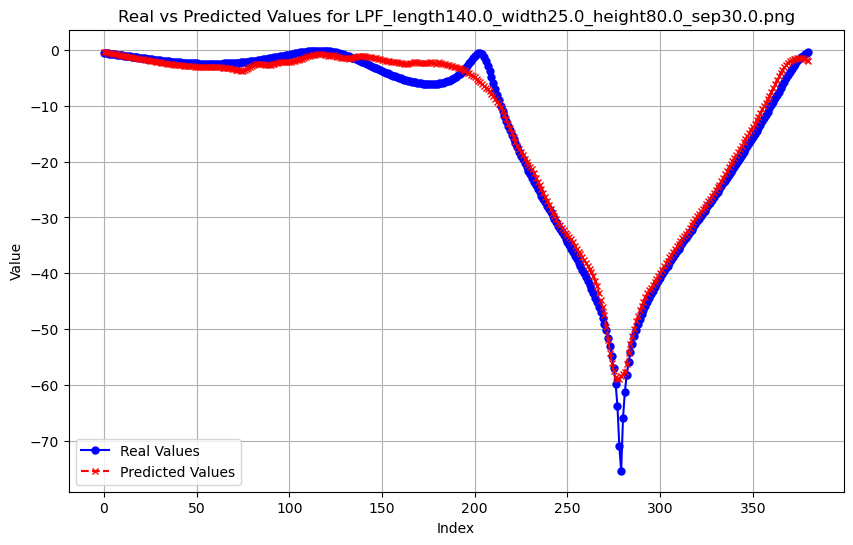

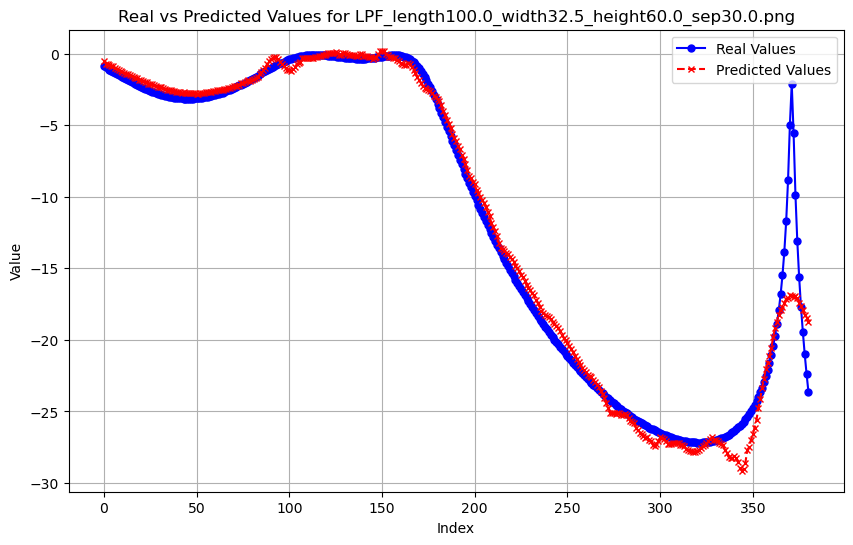

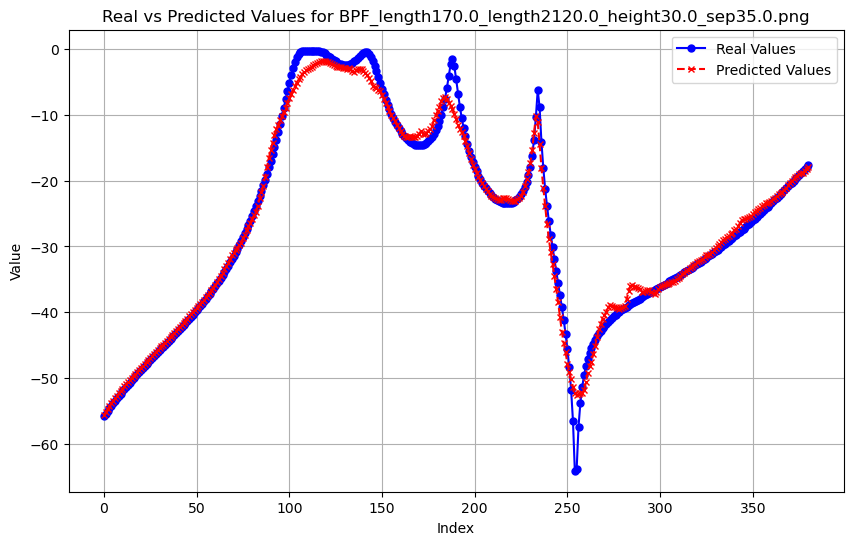

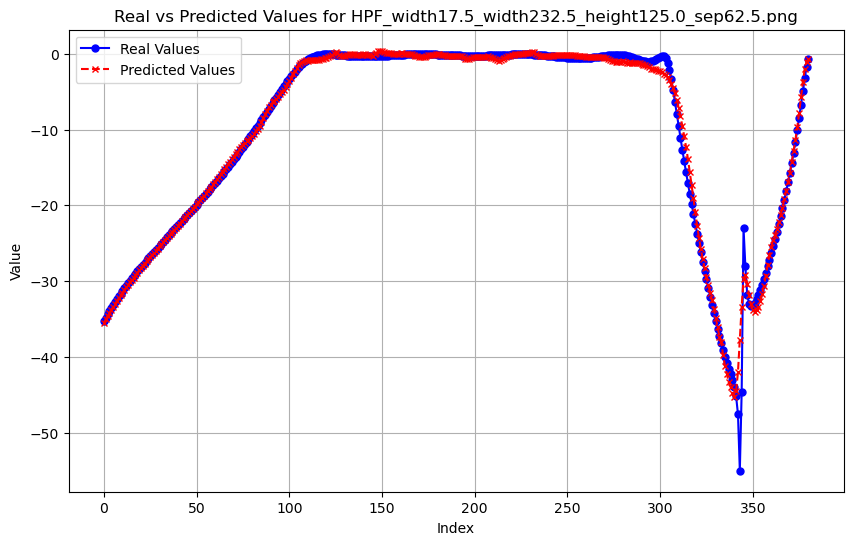

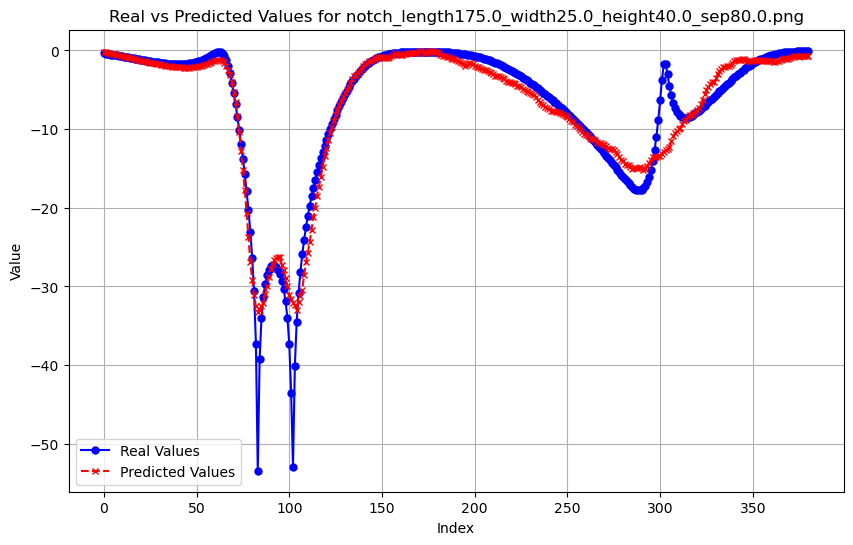

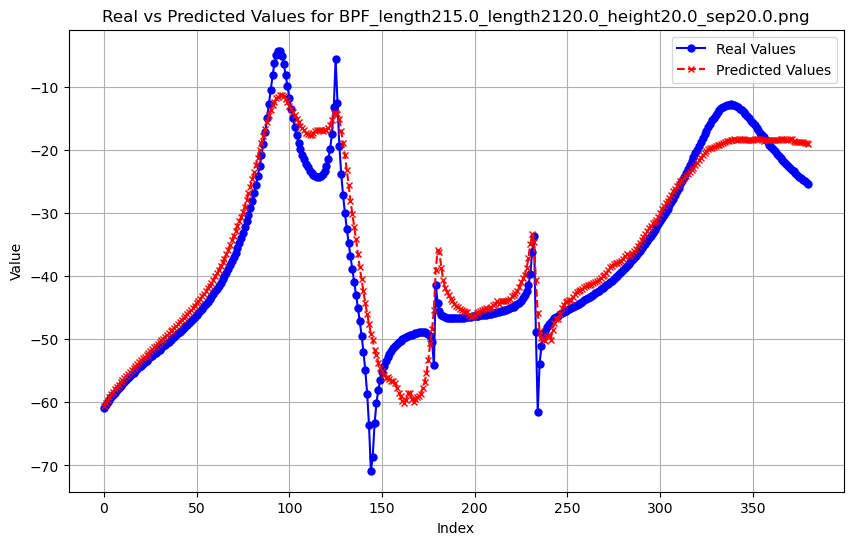

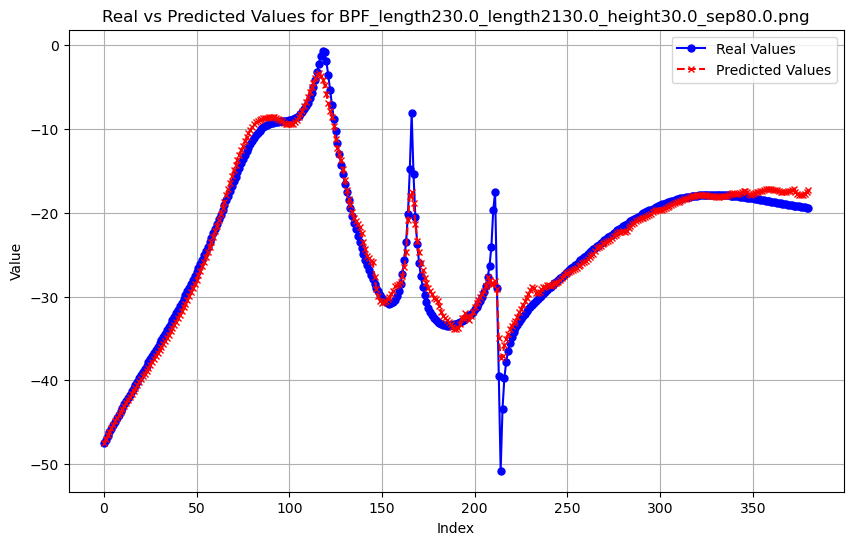

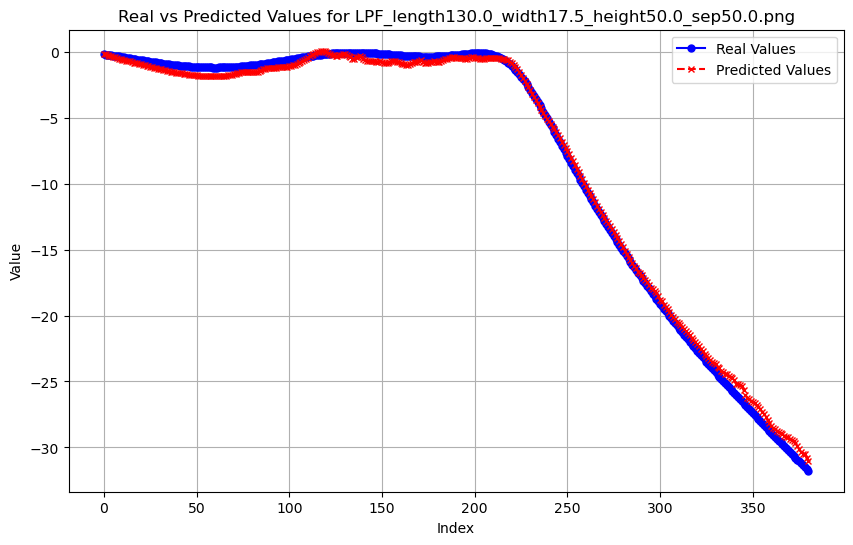

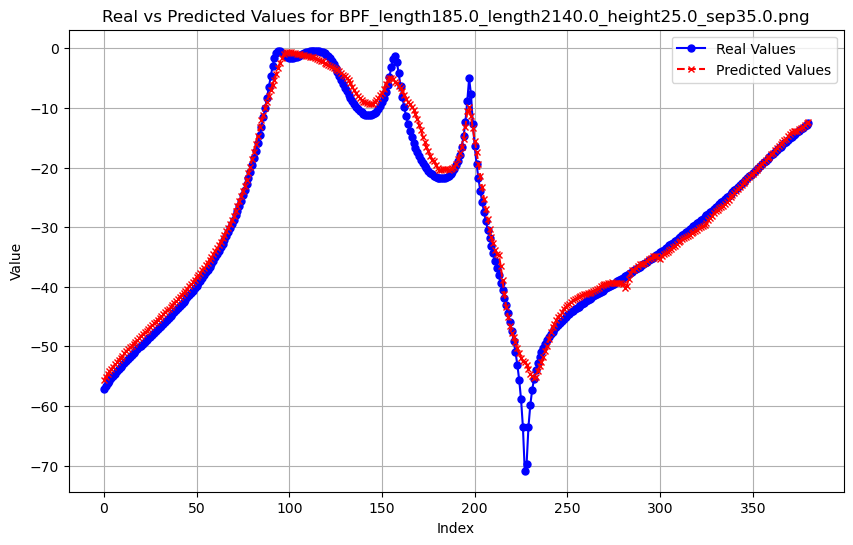

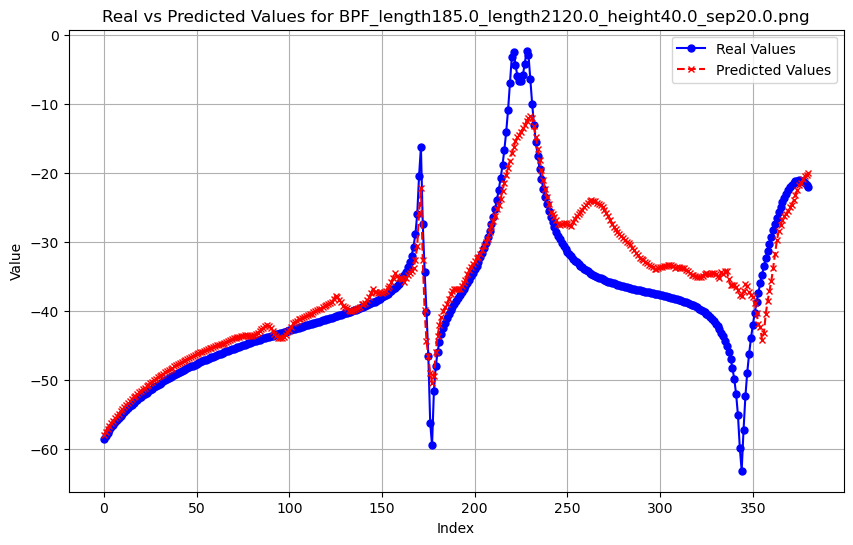

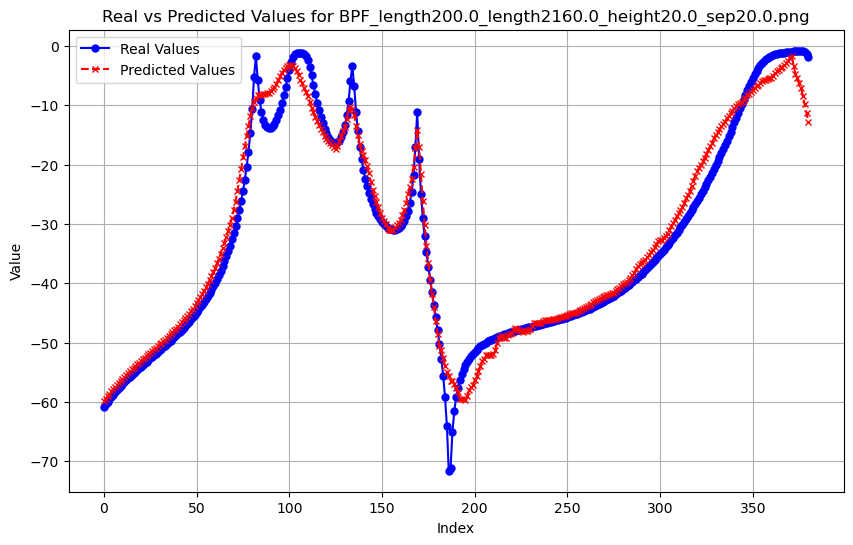

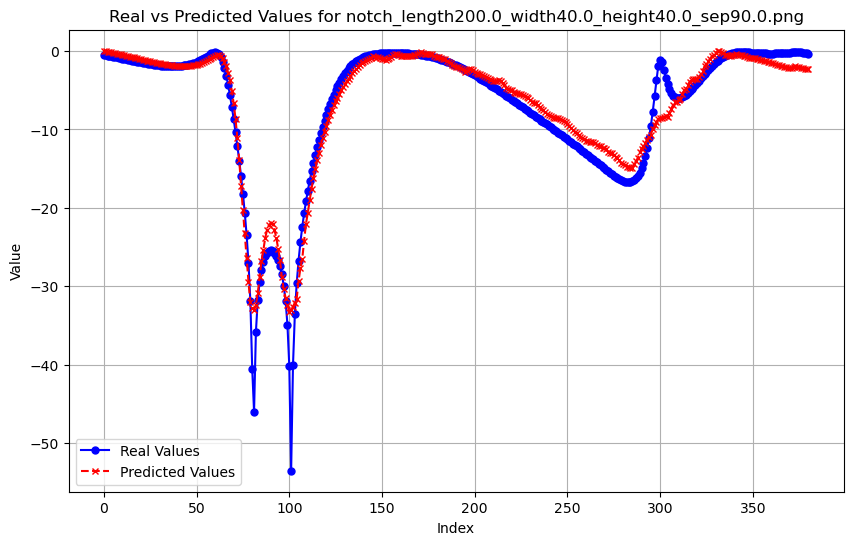

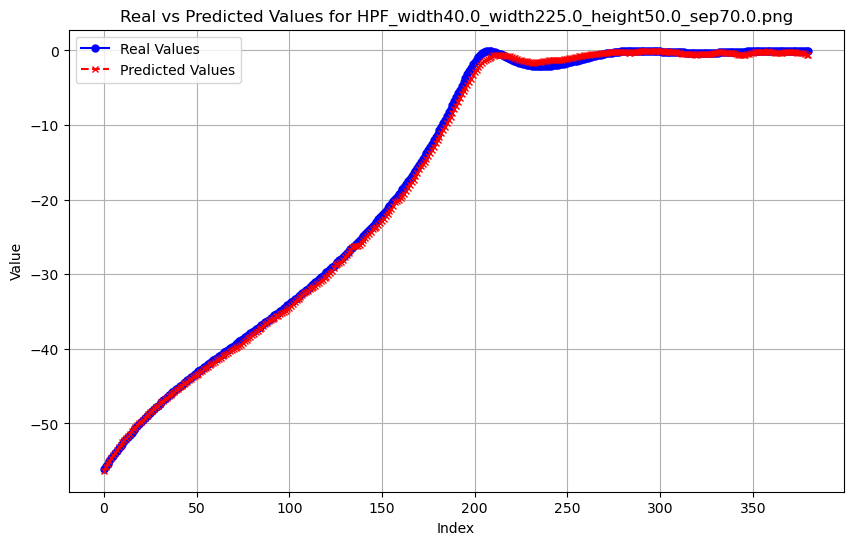

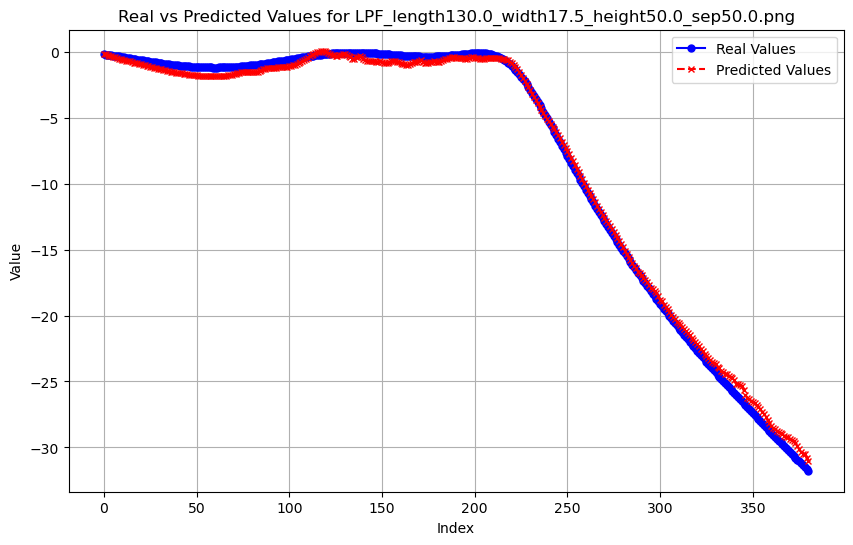

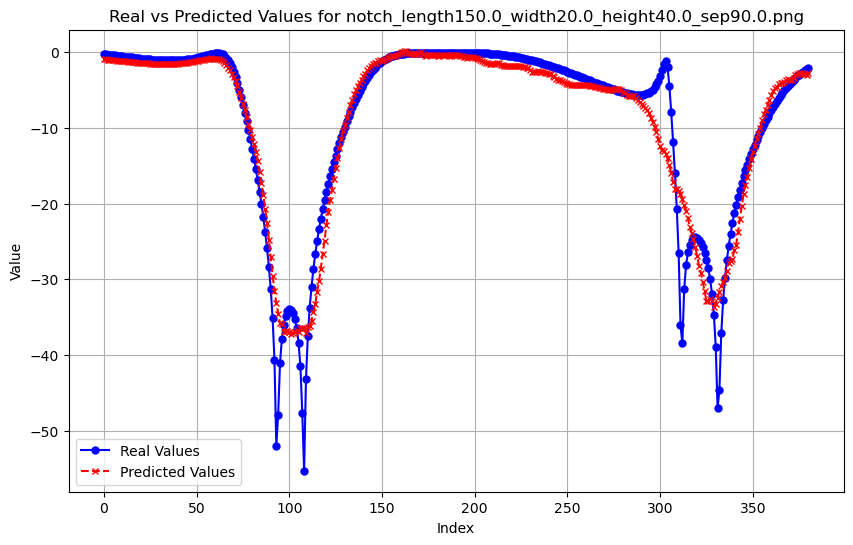

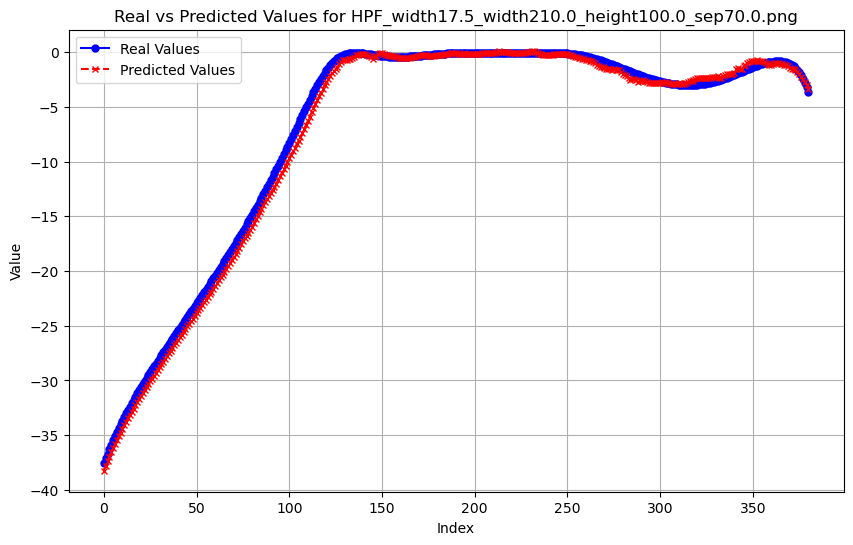

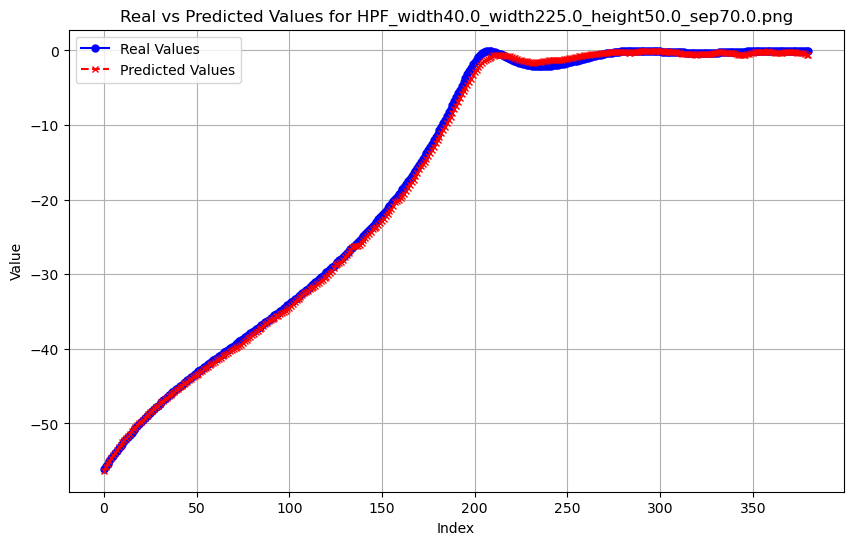

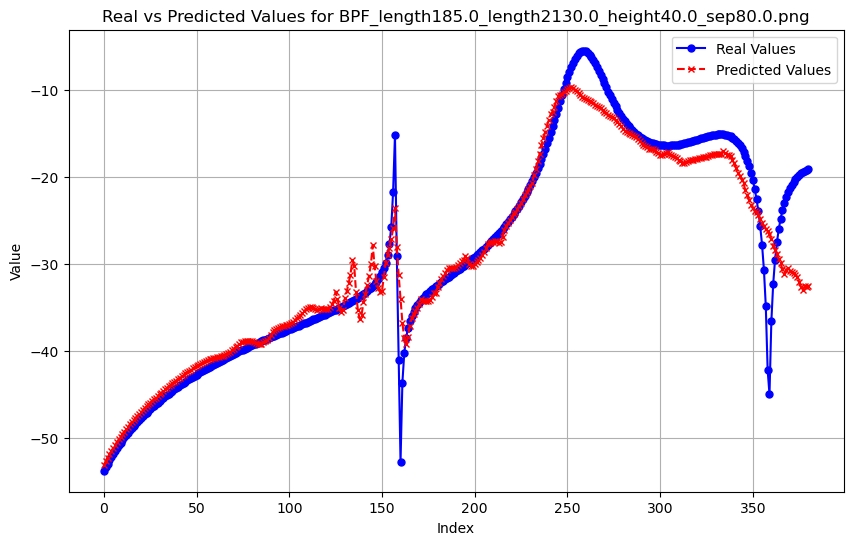

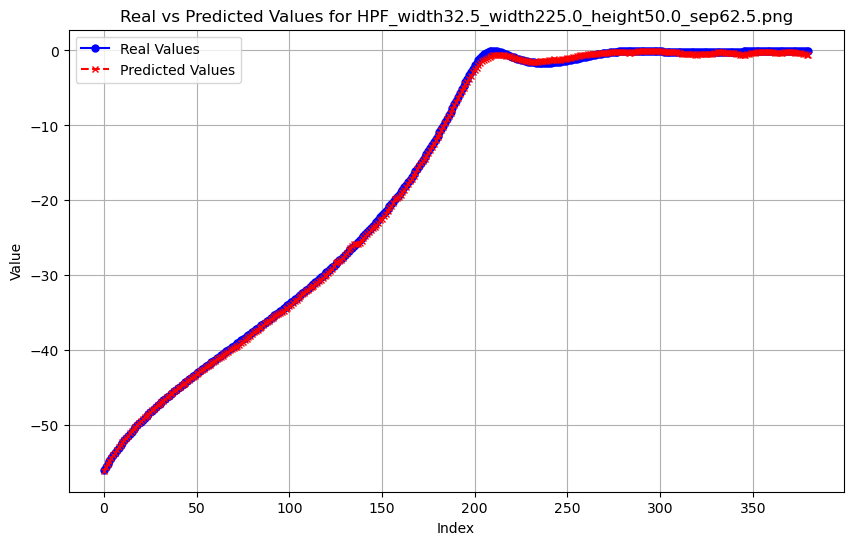

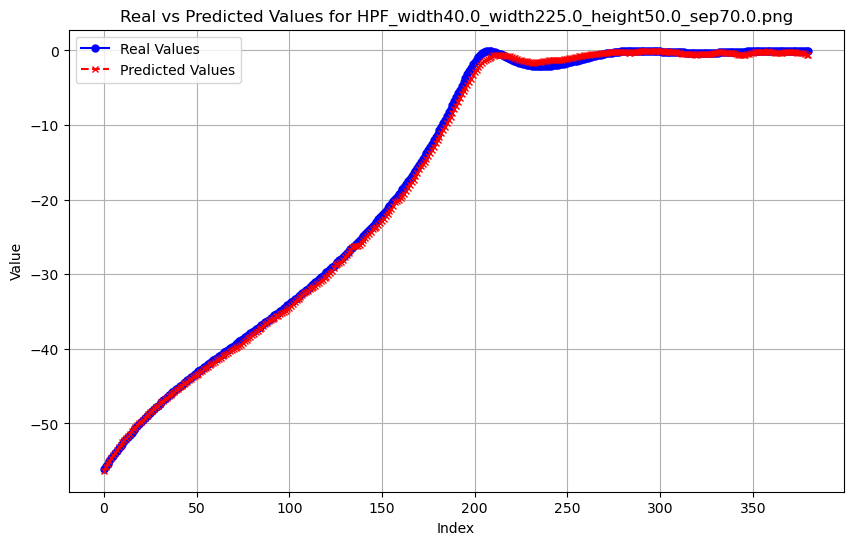

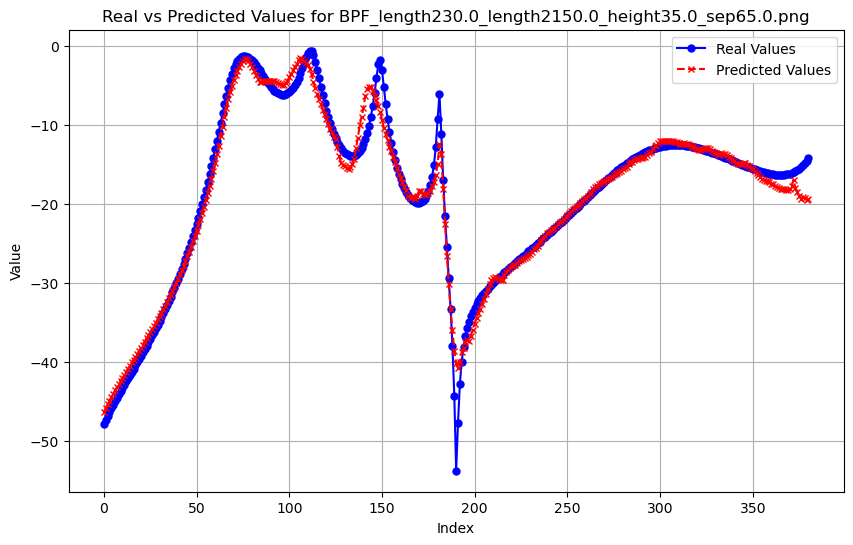

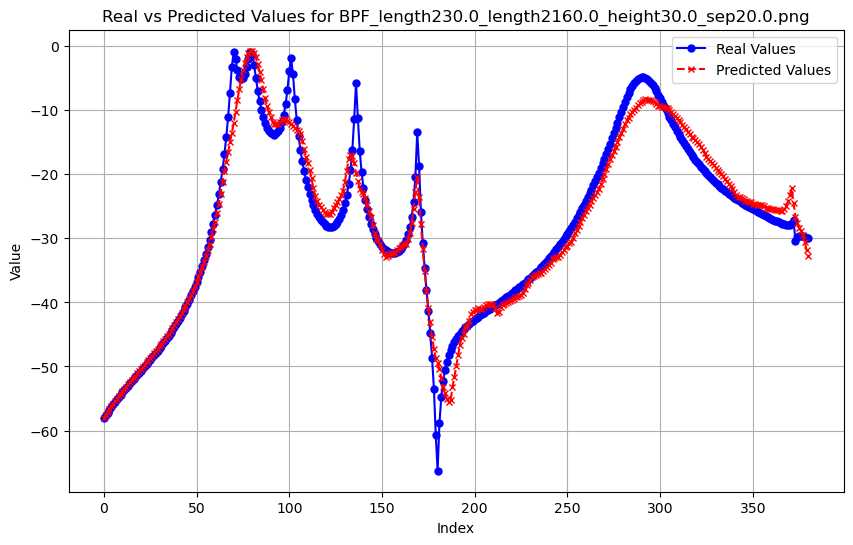

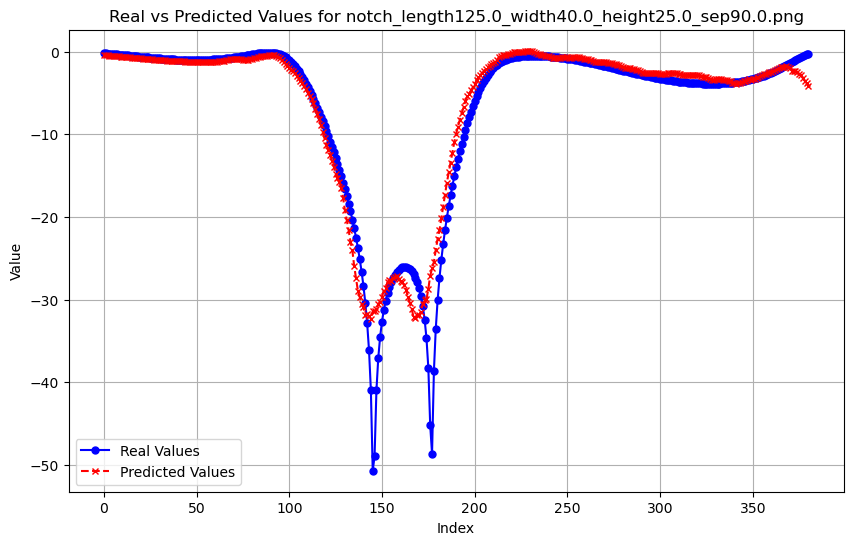

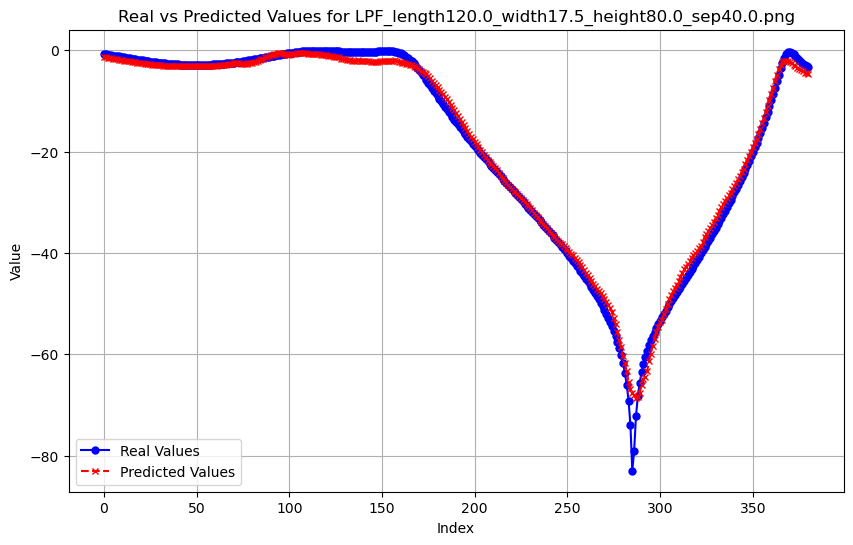

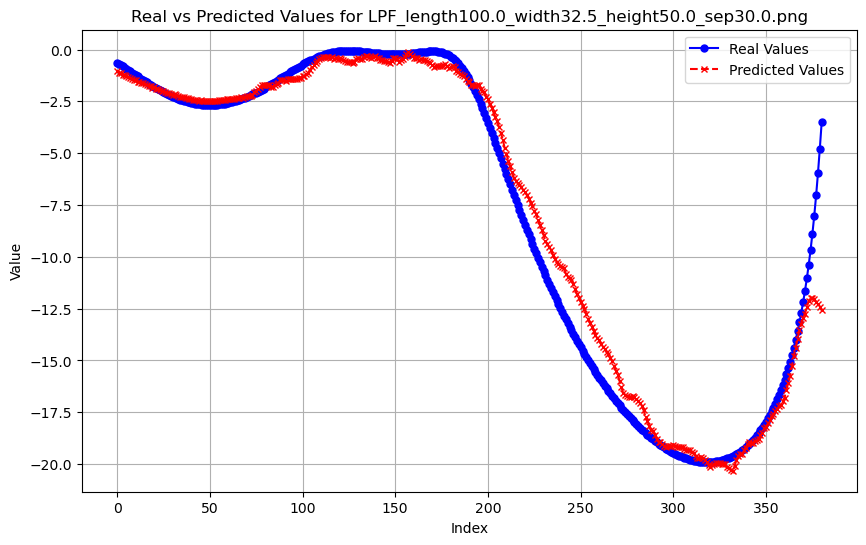

Worst Case single frequency discrepancy: 3.4811352072808375
Average single frequency discrepancy across 25 samples: 1.2207814211829398


In [79]:
model_path = f'./CapstoneFull_epoch_500.pth'  # Path to the saved neural network model

# Initialize the neural network with the specified output length
net = CircuitFrequencyResponseModel(output_length=num_outputs)  

# Load only the weights from the neural network model, using CPU as the map location
net.load_state_dict(torch.load(model_path, weights_only=True, map_location=torch.device('cpu')))

t0 = 0  # Initialize the variable to track the worst-case total discrepancy
a0 = 0  # Initialize the accumulator variable for average discrepancies

check_range = 25  # Number of samples over which to check and average discrepancies

for i in range(check_range):
    # Select a random test image from the validation set
    test_image = choose_random_file("./val_images")  
    image_path = f'./val_images/{test_image}'  # Construct the full path to the image
    
    # Obtain predicted values for the image using the neural network
    predicted_values = predict_output(net, image_path, transform)  
    
    # Plot predictions against real values and retrieve total and average discrepancy
    t, a = plot_predictions_vs_real(test_image, predicted_values)
    
    # Update worst case discrepancy if the current one is greater
    if t > t0:
        t0 = t
    
    # Add the average discrepancy to the accumulator
    a0 += a

# Calculate and print the worst-case single frequency discrepancy
print(f"Worst Case single frequency discrepancy: {t0/num_outputs}")

# Calculate and print the average single frequency discrepancy across samples
print(f"Average single frequency discrepancy across {check_range} samples: {a0/check_range}")